In [2]:
import matplotlib
from matplotlib import pyplot as plt
from PIL import Image
import torch
from transformers import GLPNImageProcessor, GLPNForDepthEstimation

In [3]:
feature_extractor = GLPNImageProcessor.from_pretrained("vinvino02/glpn-nyu")
model = GLPNForDepthEstimation.from_pretrained("vinvino02/glpn-nyu")

c:\Users\Kyler\VSCode projects\depth3D\.venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Kyler\.cache\huggingface\hub\models--vinvino02--glpn-nyu. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular 

In [5]:
image = Image.open("../data/a3.jpg")
new_height = 480 if image.height > 480 else image.height
new_height -= (new_height % 32)
new_width = int(new_height * image.width / image.height)
diff = new_width % 32
new_width = new_width - diff if diff < 16 else new_width + 32 - diff
new_size = (new_width, new_height)
image = image.resize(new_size)

In [7]:
inputs = feature_extractor(images=image, return_tensors="pt")

In [8]:
with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth

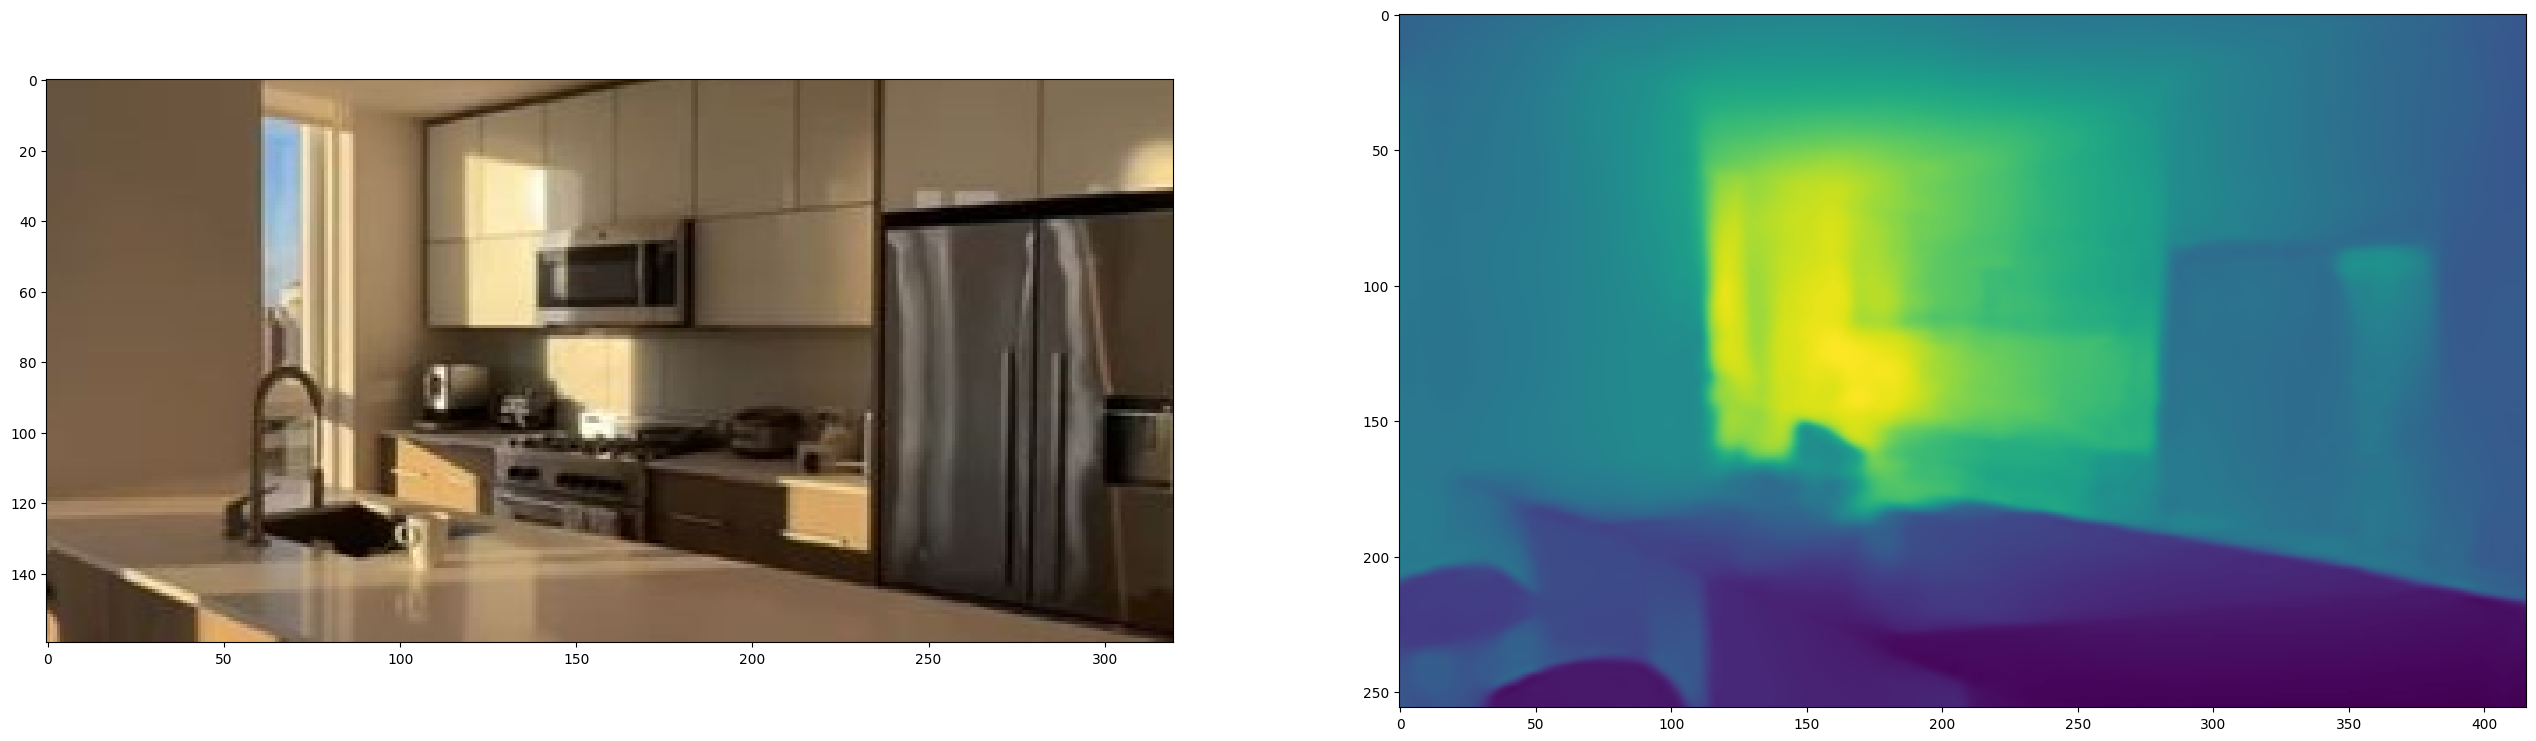

In [13]:
pad = 16
output = predicted_depth.squeeze().cpu().numpy() * 1000.0
output = output[pad:-pad, pad:-pad]
image = image.crop((pad, pad, image.width - pad, image.height - pad))

fig, ax = plt.subplots(1, 2, figsize=(32, 16))
ax[0].imshow(image)
ax[1].imshow(output)